In [1]:
import numpy as np
from numpy import linalg

from matplotlib import animation
import matplotlib.pyplot as plt

from video_utils import convert_mp4_to_jpgs, make_gif, animate

In [2]:
ITERATIONS = 50_000
EPS = 1e-3
X_0 = 1.5

### 1. Реализуйте градиентный спуск с постоянным шагом (learning rate).

In [3]:
class GradDescGeneral:
    def __init__(
            self,
            fn,
            derivative,
    ):
        self.fn = fn
        self.derivative = derivative

    def __call__(
            self,
            starting_point: np.ndarray,
            iterations: int,
            linear_method,
            eps: float = EPS ** 2
    ):
        path = []
        cur_x = starting_point
        iteration = 0
        for iteration in range(iterations):
            path.append((cur_x, self.fn(cur_x)))

            gradient = self.derivative(cur_x)
            
            lr = linear_method(cur_x, gradient)

            new_x = cur_x - lr * gradient

            if np.alltrue(np.abs(cur_x - new_x) < eps):
                break

            cur_x = new_x

        return cur_x, path, iteration + 1

In [4]:
class DefaultMethod:
    def __init__(self, lr: float) -> None:
        self.lr = lr
        
    def __call__(self, cur_x, gradient):
        return self.lr

In [5]:
import math

def fn(x): 
    return x * math.sin(x)
    
def derivative(x):
    return x * math.cos(x) + math.sin(x)

fn = np.vectorize(fn)
derivative = np.vectorize(derivative)

In [6]:
lrs = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

data = []

X_0 = 3

for lr in lrs:
    optimizer = GradDescGeneral(fn, derivative)
    result = optimizer(X_0, ITERATIONS, linear_method=DefaultMethod(lr))
    data.append((*result, lr))

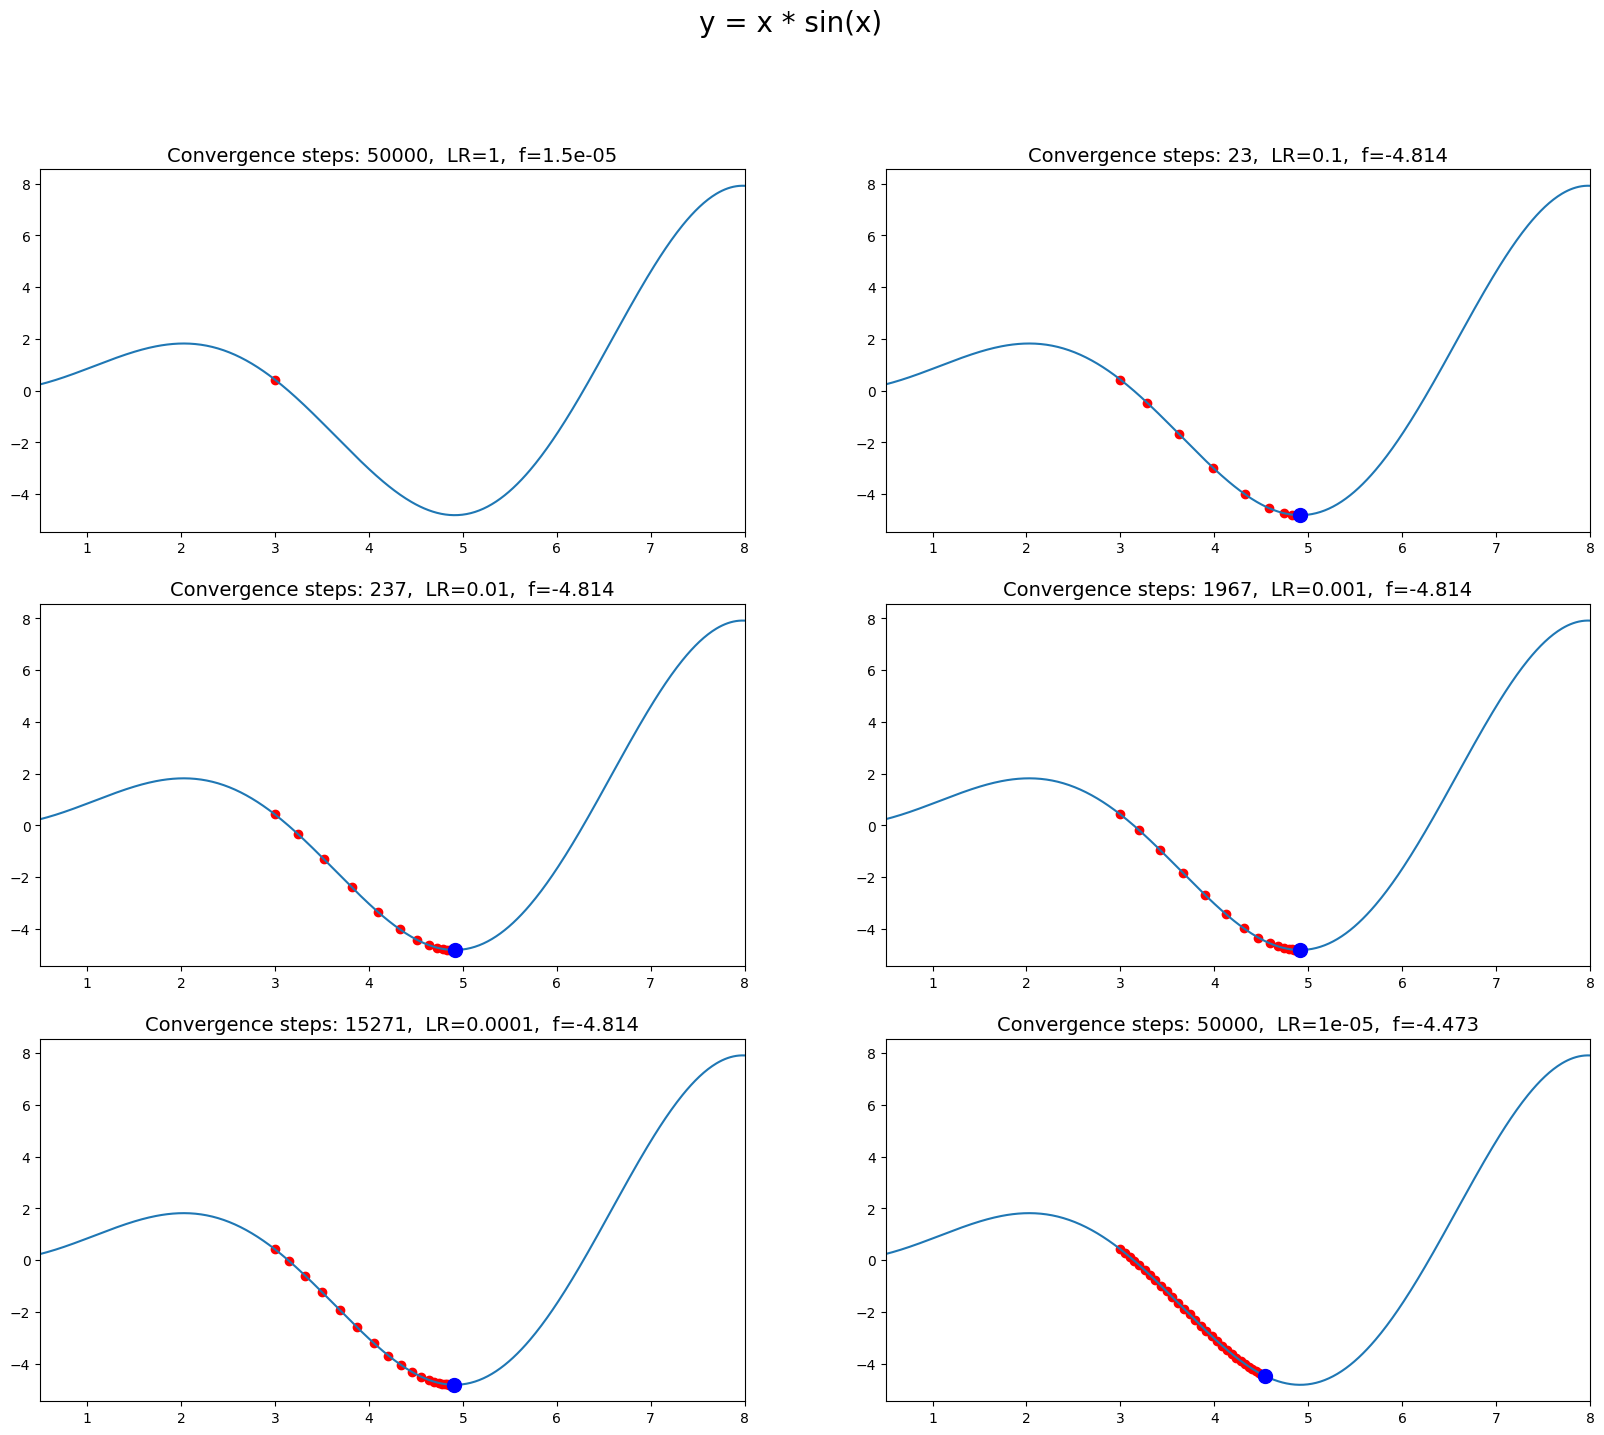

In [7]:
from graphs import plot1d_descent 

cols = 2
rows = len(data) // cols

figure, axs = plt.subplots(rows, cols, figsize=(20, 16))
figure.suptitle("y = x * sin(x)", fontsize=20)

for i, (minimum_x, path, made_steps, lr) in enumerate(data):
    col = i % 2
    row = i // 2
    ax = axs[row][col]

    plot1d_descent(i, minimum_x, fn, path, ax, x_range=(0.5, 8))
    ax.set_title(f"Convergence steps: {made_steps},  LR={lr},  f={fn(minimum_x):.4}", fontsize=14)

plt.show()

### 2. Реализуйте метод одномерного поиска (метод дихотомии, метод Фибоначчи, <br/> метод золотого сечения) и градиентный спуск на его основе. (Выбрали дихотомию)

In [8]:
def dichotomy(fn, eps = EPS):
    delta = eps / 3

    def cycle(interval):
        def inner_cycle(interval, path):
            left, right = interval

            middle = (left + right) / 2

            path.append((middle, fn(middle)))

            if right - left < eps:
                return middle

            x_l, x_r = middle - delta, middle + delta
            fn_l, fn_r = fn(x_l), fn(x_r)

            if fn_l < fn_r:
                interval = (left, x_r)
            elif fn_l > fn_r:
                interval = (x_l, right)
            else:
                interval = (x_l, x_r)

            return inner_cycle(interval, path)

        path = []
        x = inner_cycle(interval, path)
        return x, path

    return cycle

### Проверим просто поиск минимума функции, используя дихотомию

In [9]:
dichotomy_method = dichotomy(fn)

x, trace = dichotomy_method((-10, 15))
print(x, fn(x))

# mp4 dichotomy.mp4

11.085605547587079 -11.040707990639548


#### Теперь дихотомия + одномерный поиск

In [10]:
def lin_constraint(fn, N_STEPS: int = 100):
    middle = 0.5

    fn_l = fn(0)
    fn_r = fn(middle)

    for _ in range(N_STEPS):
        if fn_l >= fn_r:
            break

        middle /= 2
        fn_r = fn(middle)

    right = 2 * middle
    
    if abs(right) < EPS:
        return EPS

    for _ in range(N_STEPS):
        if fn(right) >= fn_r:
            break

        right *= 2

    return right

In [11]:
class DichotomyMethod:
    def __init__(self, fn, eps = EPS):
        self.f = fn
        self.eps = eps
        
    def __call__(self, cur_x, gradient):
        best_lr_fn = lambda lr: self.f(cur_x - lr * gradient)
        max_lr = lin_constraint(best_lr_fn)
        interval = 0, max_lr
        best_lr, _ = dichotomy(best_lr_fn, self.eps)(interval)
        
        # print(f"{best_lr=}")

        return best_lr

total steps = 2558, method=DefaultMethod
f(x_min) = -4.81446979425798, x_min = -4.91298907594682


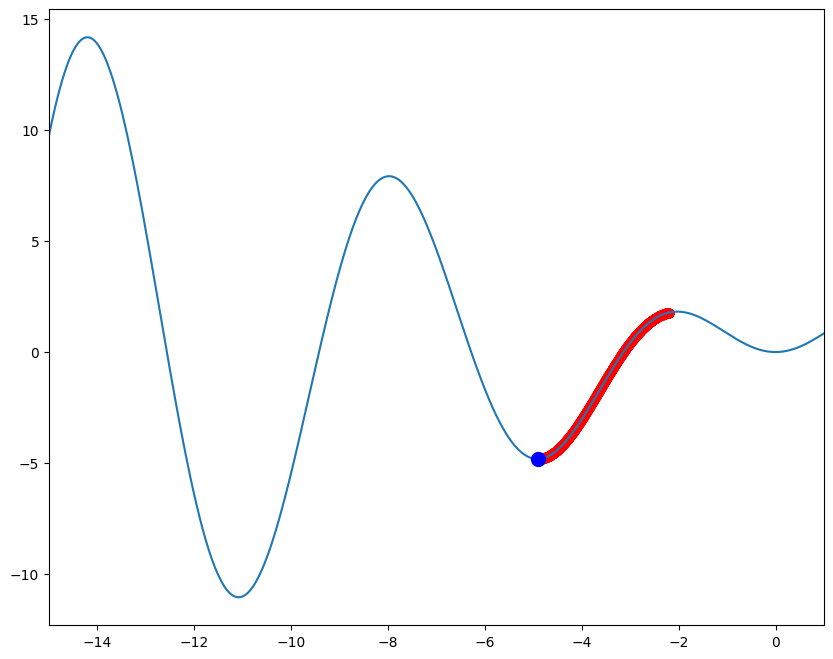

total steps = 3, method=DichotomyMethod
f(x_min) = -11.040708015929999, x_min = -11.085538388631676


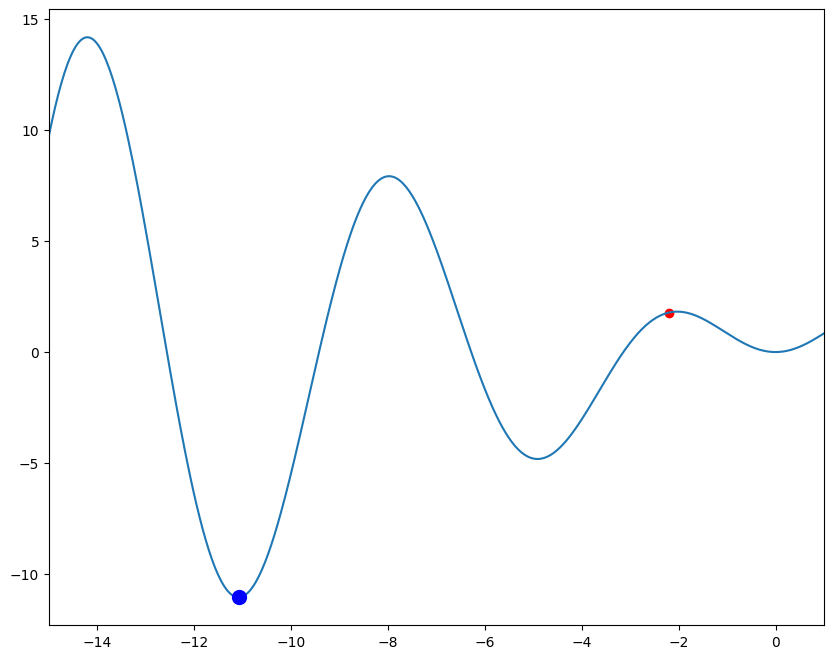

In [12]:
starting_point = -2.2

methods = [DefaultMethod(EPS), DichotomyMethod(fn)]

for idx, method in enumerate(methods):
    optimizer = GradDescGeneral(fn, derivative)

    x_min, path, convergence_steps = optimizer(
        starting_point=starting_point,
        iterations=ITERATIONS,
        linear_method=method
    )
    
    figure, ax = plt.subplots(figsize=(10, 8))

    print(f"total steps = {convergence_steps}, method={method.__class__.__name__}")
    print(f"f(x_min) = {fn(x_min)}, x_min = {x_min}")
    plot1d_descent(0, x_min, fn, path, ax, freq='every', x_range=(-15, 1))
    plt.show()


### Можно выделить следующие аспекты:
1. Мы вычисляли функцию и её градиент НАМНОГО меньше => менее ресурсоёмко.
2. Быстрота сходимости сильно увеличилась
По сути одномерный поиск каждый раз удовлетворяет следующей задаче на каждом шаге (подбирая соответсвующий learning rate):

$\underset{\beta_j > 0}{\min} \tilde{f}(\beta_j) = \underset{\beta_j > 0}{\min} f(\mathbb{x}_{j-1} + \beta_j \mathbb{\delta}_j)$

[Ссылка на статью](https://indrag49.github.io/Numerical-Optimization/line-search-descent-methods.html#eq:3)

### 3. Проанализируйте траекторию градиентного спуска. Для этого придумайте две-три квадратичные функции от двух переменных

In [13]:
representations = ["100 * x ^ 2 + x * y + y ^ 2",
                   "(x ^ 2 + 2 * y) ^ 2 + y ^ 4",
                   "(x ^ 2 - y) ^ 2"]

fns = [lambda args: 100 * (args[0] ** 2) + args[0] * args[1] + args[1] ** 2,
      lambda args: (args[0] ** 2 + 2 * args[1]) ** 2 + args[1] ** 4,
      lambda args: (args[0] ** 2 - args[1] ) ** 2]

destructured_fns = [
      lambda x, y: 100 * (x ** 2) + x * y + y ** 2,
      lambda x, y: (x ** 2 + 2 * y) ** 2 + y ** 4,
      lambda x, y: (x ** 2 - y) ** 2
]

derivatives = [lambda args: np.array([2 * 100 * args[0] + args[1], args[0] + 2 * args[1]]),
              lambda args: np.array([2 * (args[0] ** 2 + 2 * args[1]) * 2 * args[0], 2 * (args[0] ** 2 + 2 * args[1]) * 2 + 4 * (args[1] ** 3)]),
              lambda args: np.array([2 * (args[0] ** 2 - args[1]) * 2 * args[0], 2 * (args[0] ** 2 - args[1]) * (-1)])]

### 4. Для каждой функции: (пункты ...)

### Проверим, как влияет нормализация осей на дальнейшую сходимость методов:

In [14]:
from graphs import plot3d_descent

N_ITERATIONS = 100_000

starting_points=np.array([[4, -4], [5, -2], [-1.5, -1]])

================== starting_point = [ 5. -2.] ==================
================== method = DefaultMethod ==================


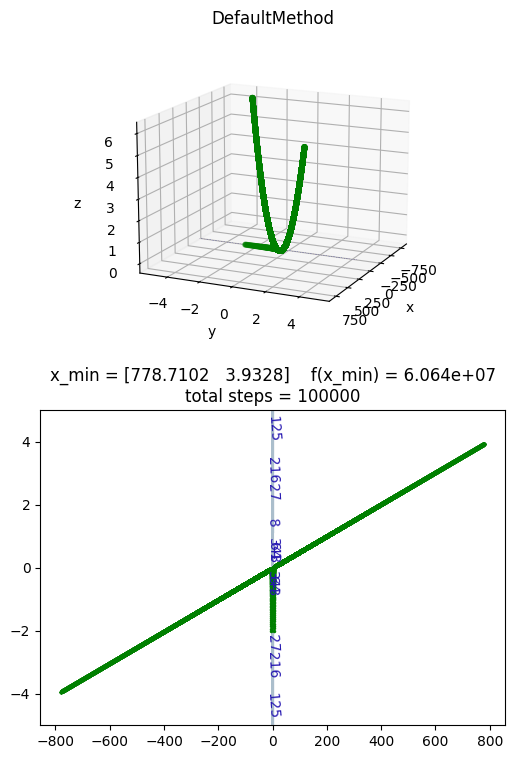

================== method = DichotomyMethod ==================


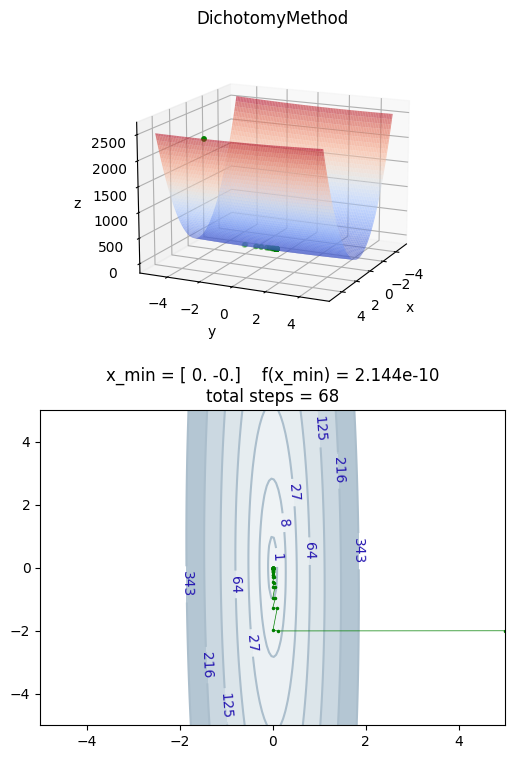

================== method = DefaultMethod ==================


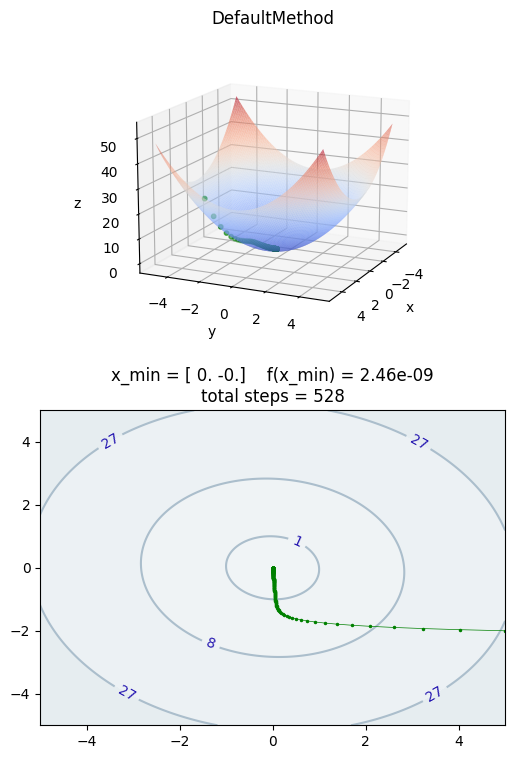

================== method = DichotomyMethod ==================


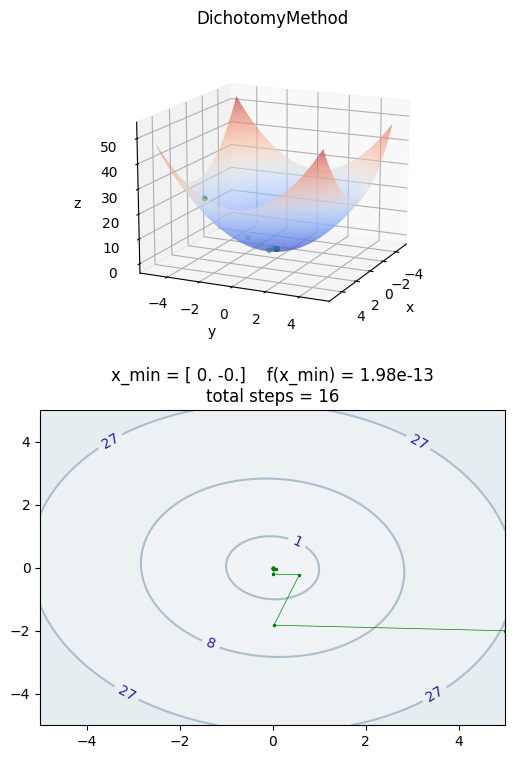

In [15]:
normalized_fn_repr = "100 * (x / 10) ^ 2 + (x / 10) * y + y ^ 2"
normalized_fn = lambda args: 100 * ((args[0] / 10) ** 2) + (args[0] / 10) * args[1] + args[1] ** 2
normalized_destructured_fn = lambda x, y: 100 * ((x / 10) ** 2) + (x / 10) * y + y ** 2
normalized_derivative = lambda args: np.array([2 * 100 * (args[0] / 10) + args[1], (args[0] / 10) + 2 * args[1]])

norm_fn = [fns[0], normalized_fn]
norm_derivatives = [derivatives[0], normalized_derivative]
norm_destructured = [destructured_fns[0], normalized_destructured_fn]

print(f"================== starting_point = {starting_points[1]} ==================")
    
for i in range(2):
    methods = [DefaultMethod(1e-2), DichotomyMethod(norm_fn[i])]
    for idx, method in enumerate(methods):
        print(f"================== method = {method.__class__.__name__} ==================")
        optimizer = GradDescGeneral(norm_fn[i], norm_derivatives[i])
        x_min, path, convergence_steps = optimizer(
            starting_point=starting_points[1],
            iterations=N_ITERATIONS,
            linear_method=method
        )
        
        new_line = '\n'
        info = [method.__class__.__name__, 
            f"x_min = {np.around(x_min, decimals=4)}    f(x_min) = {norm_fn[i](x_min):.4}{new_line}total steps = {convergence_steps}"]
        plot3d_descent(
            fn=norm_destructured[i],
            info=info,
            path=path,
            angle=(15, 25)
        )
        plt.show()

##### Итого можно наблюдать, что оба метода линейного поиска проявили себя в разы лучше на нормализованных данных.
##### За кадром проводились эксперименты и оказалось, что с нормализацией можно выставлять больший learning rate, при котором метод будет сходиться => экономия вычислительных ресурсов и времени

================== fn = 100 * x ^ 2 + x * y + y ^ 2 ==================


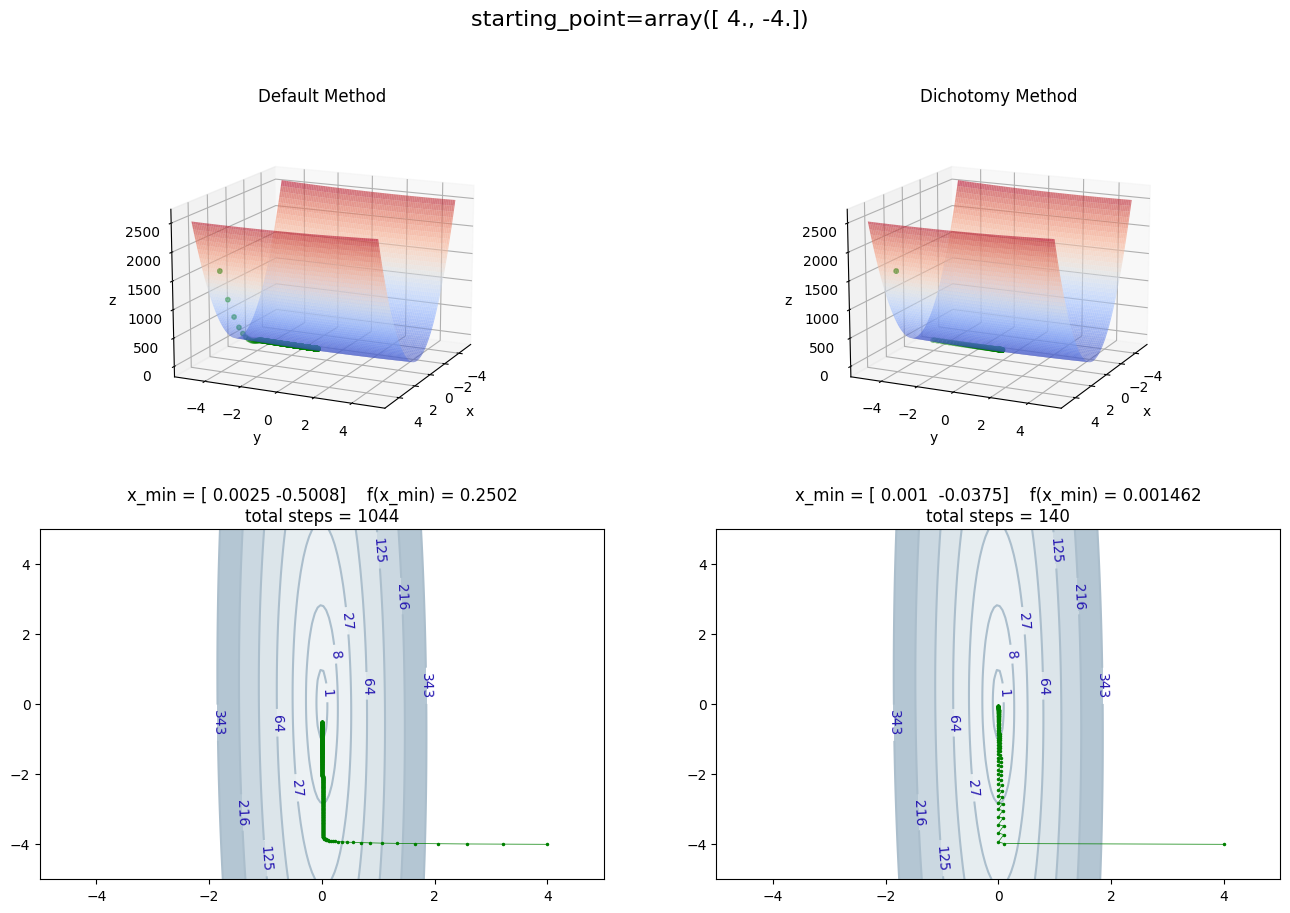

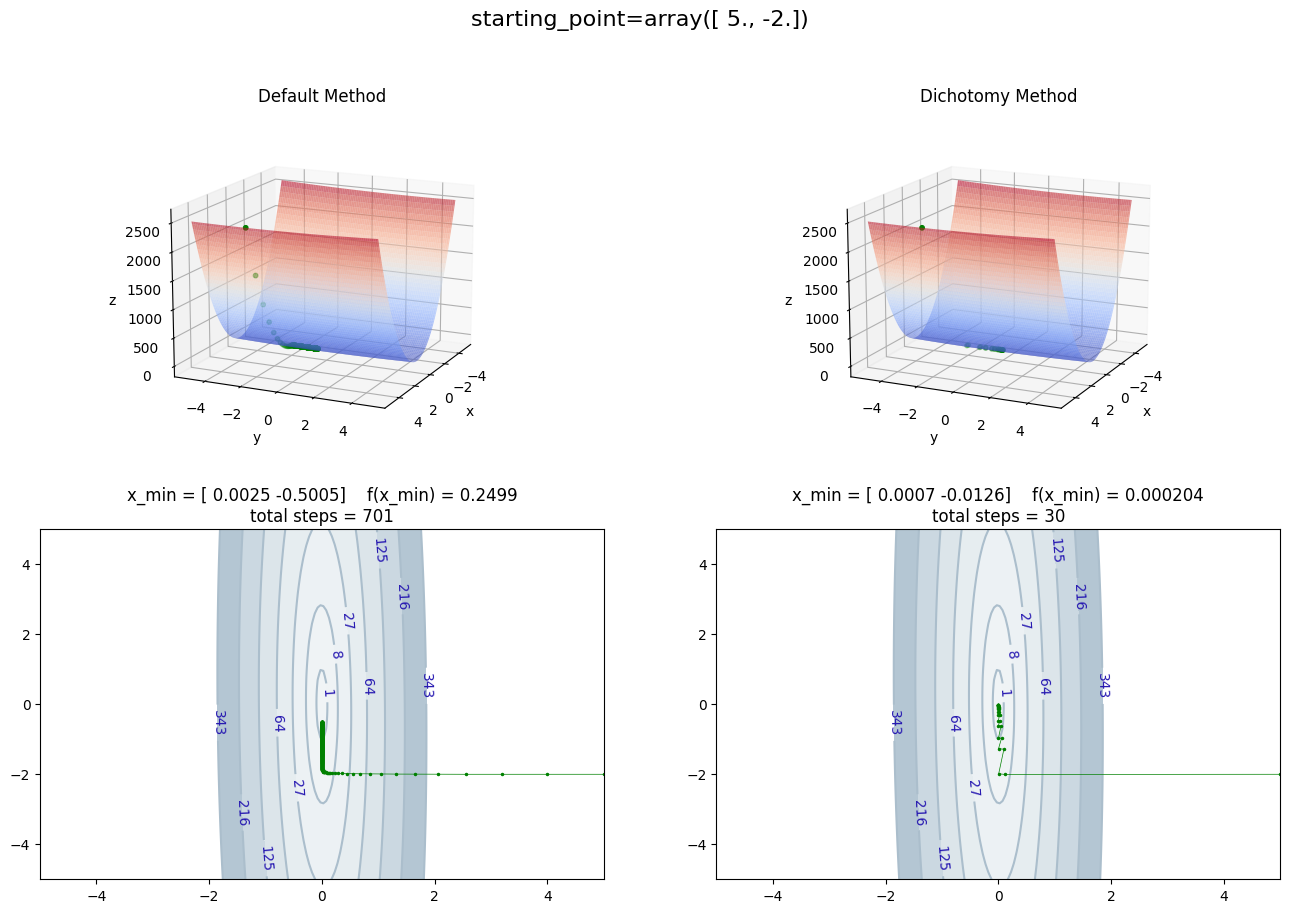

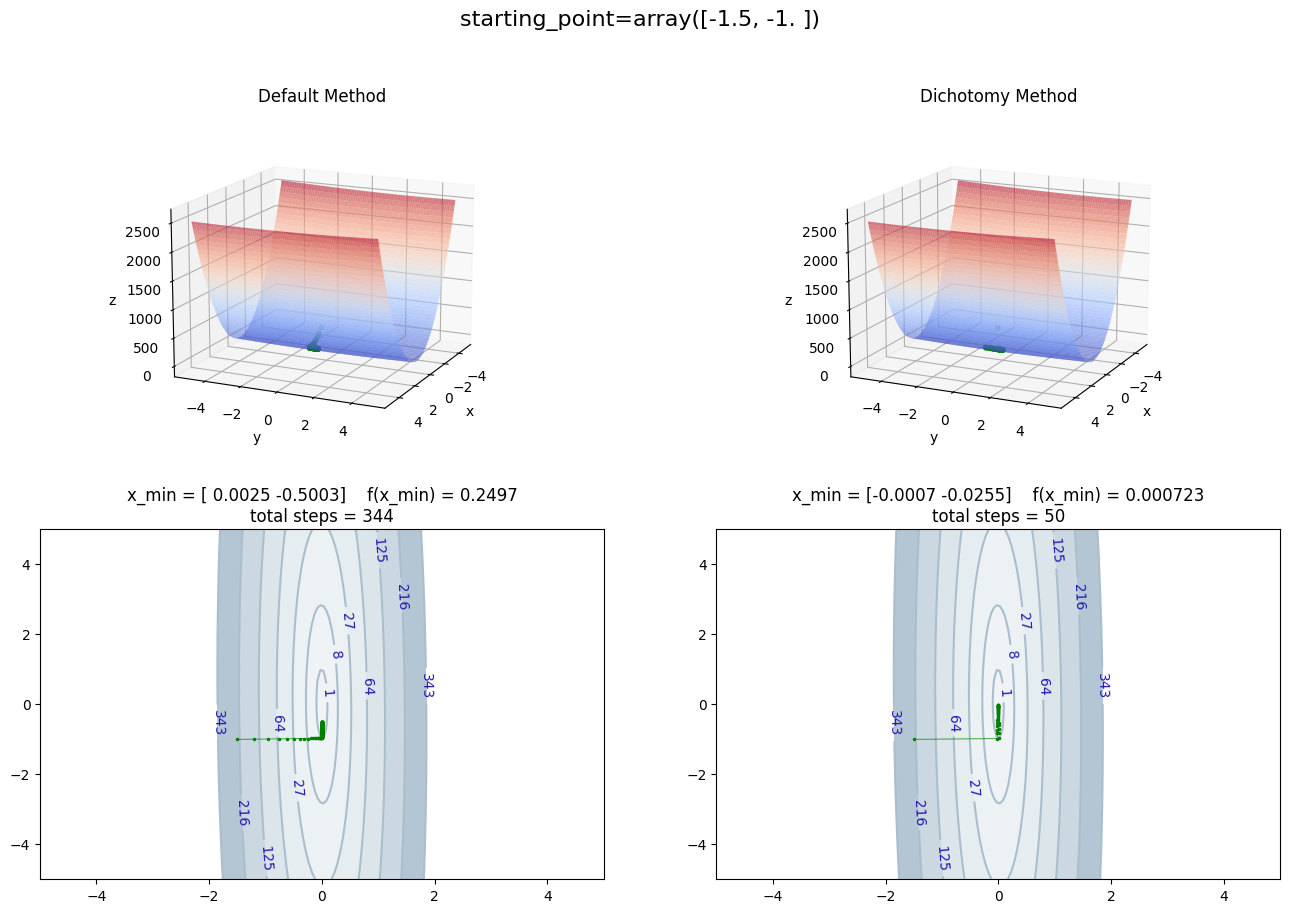

================== fn = (x ^ 2 + 2 * y) ^ 2 + y ^ 4 ==================


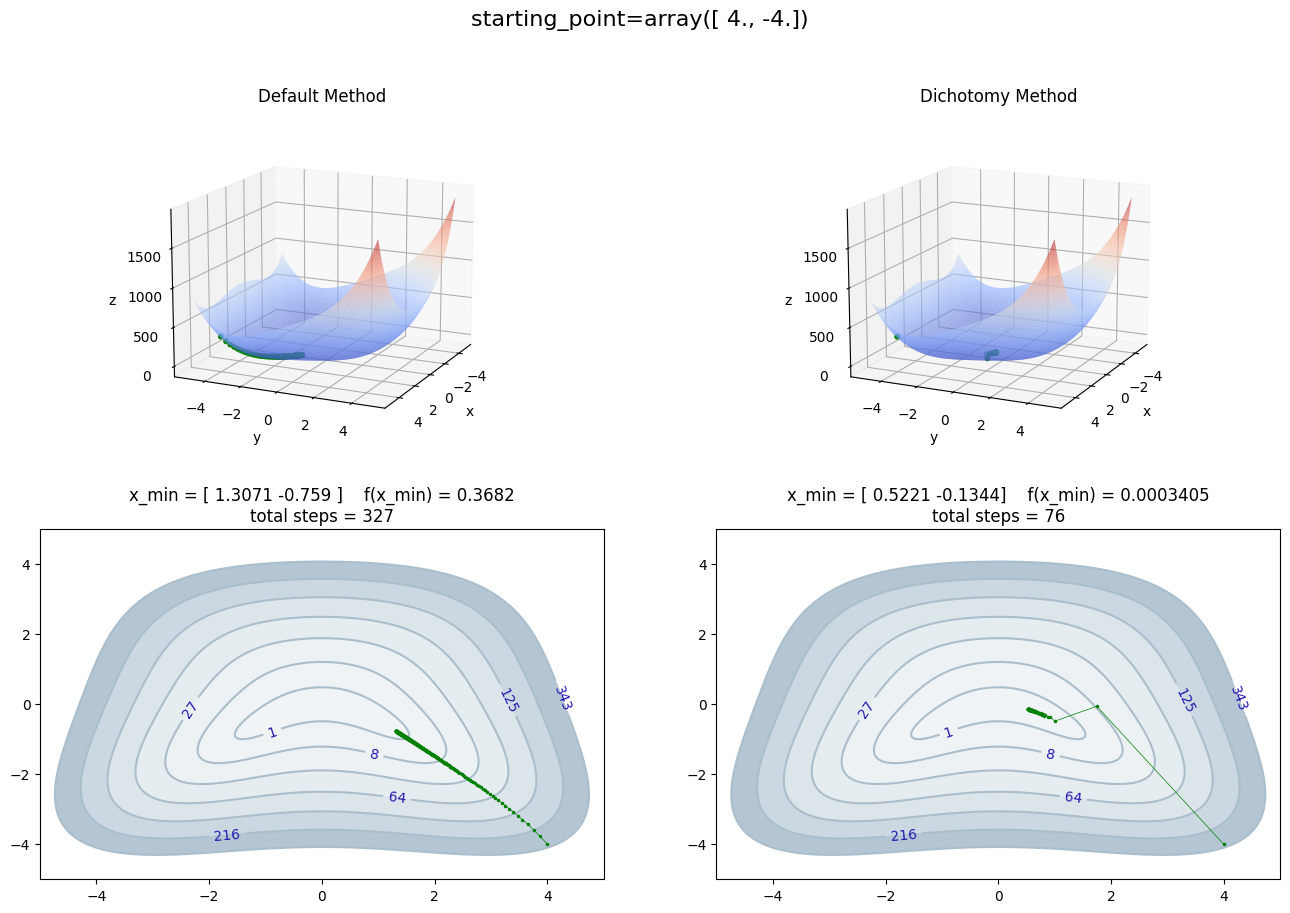

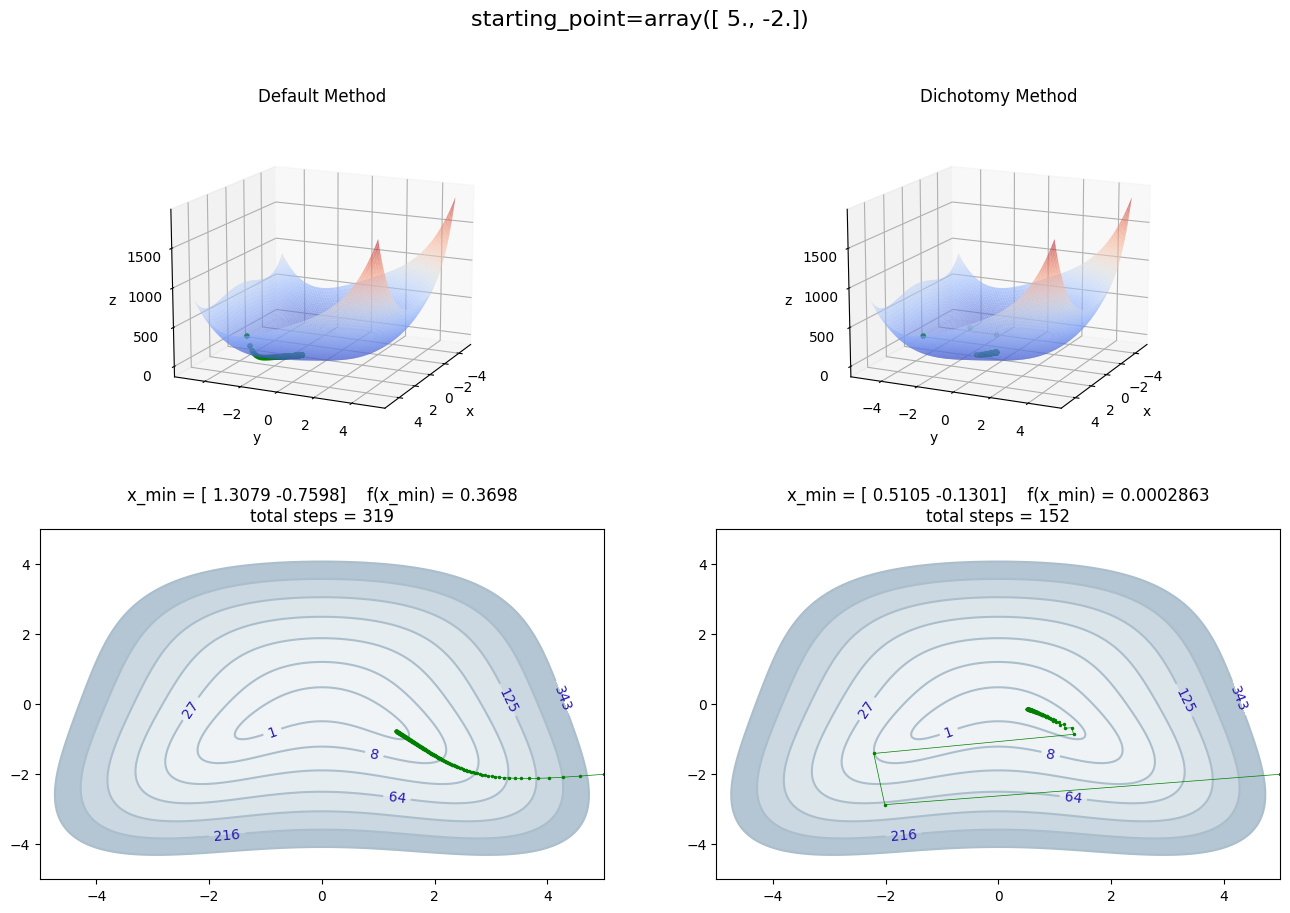

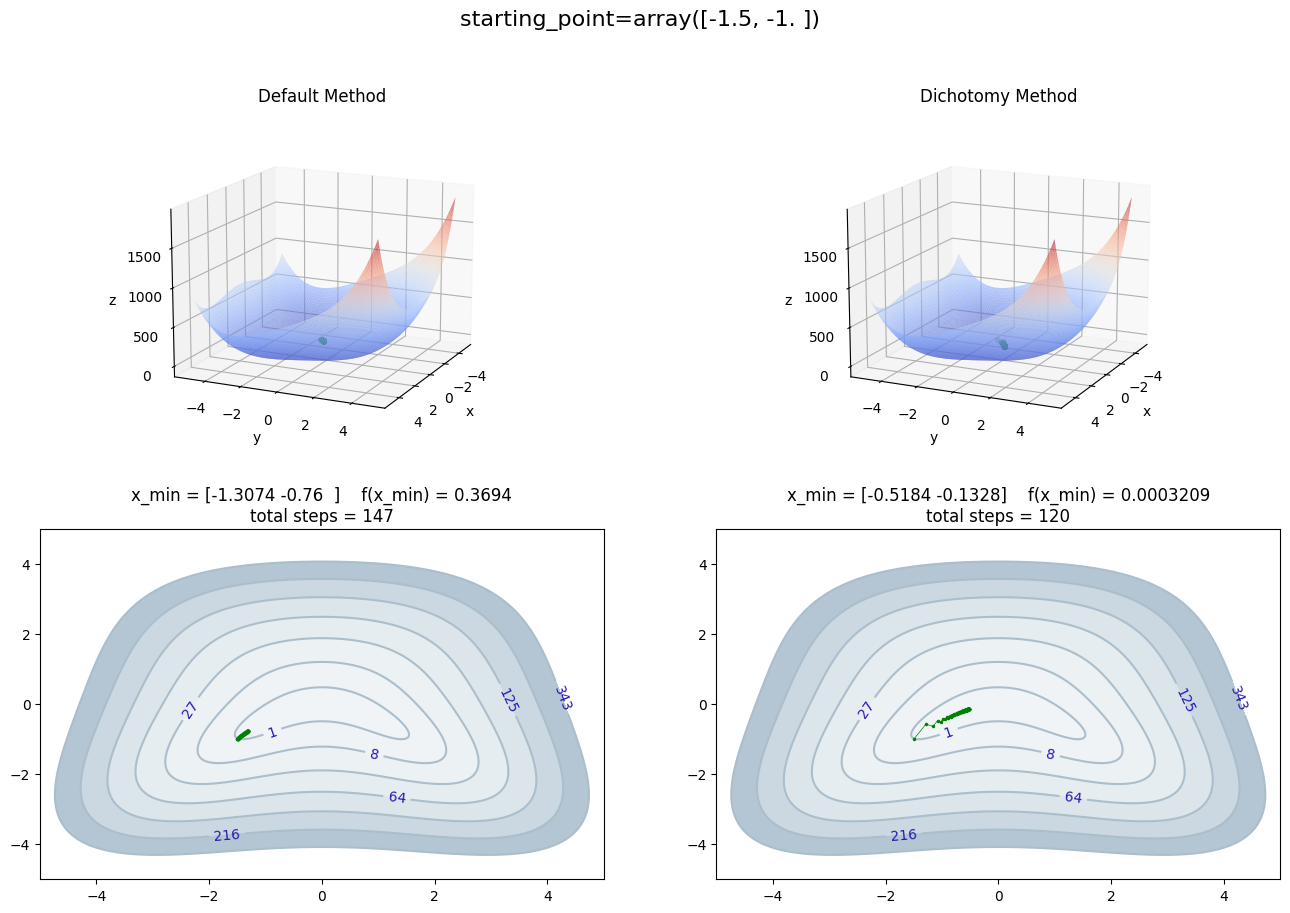

================== fn = (x ^ 2 - y) ^ 2 ==================


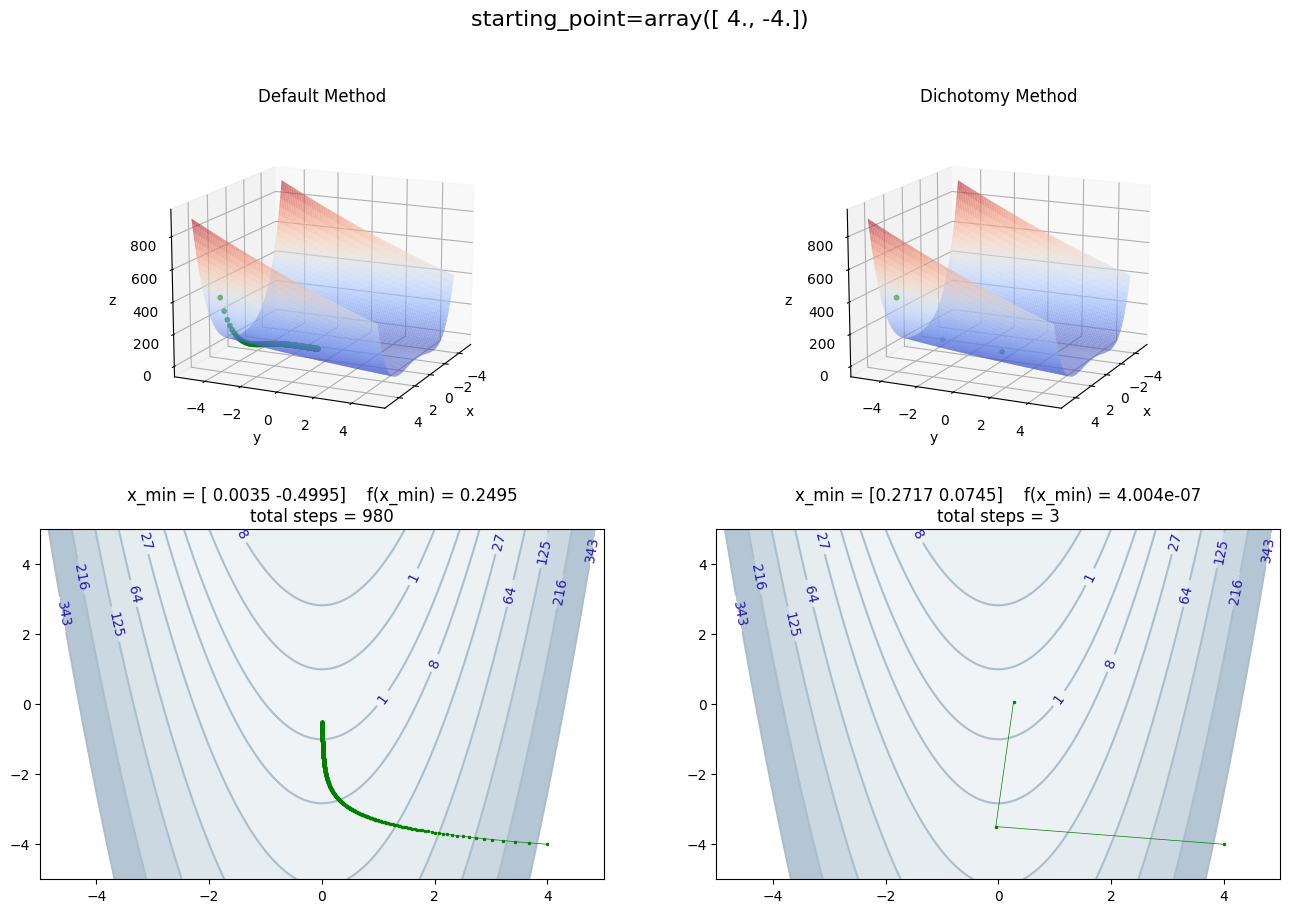

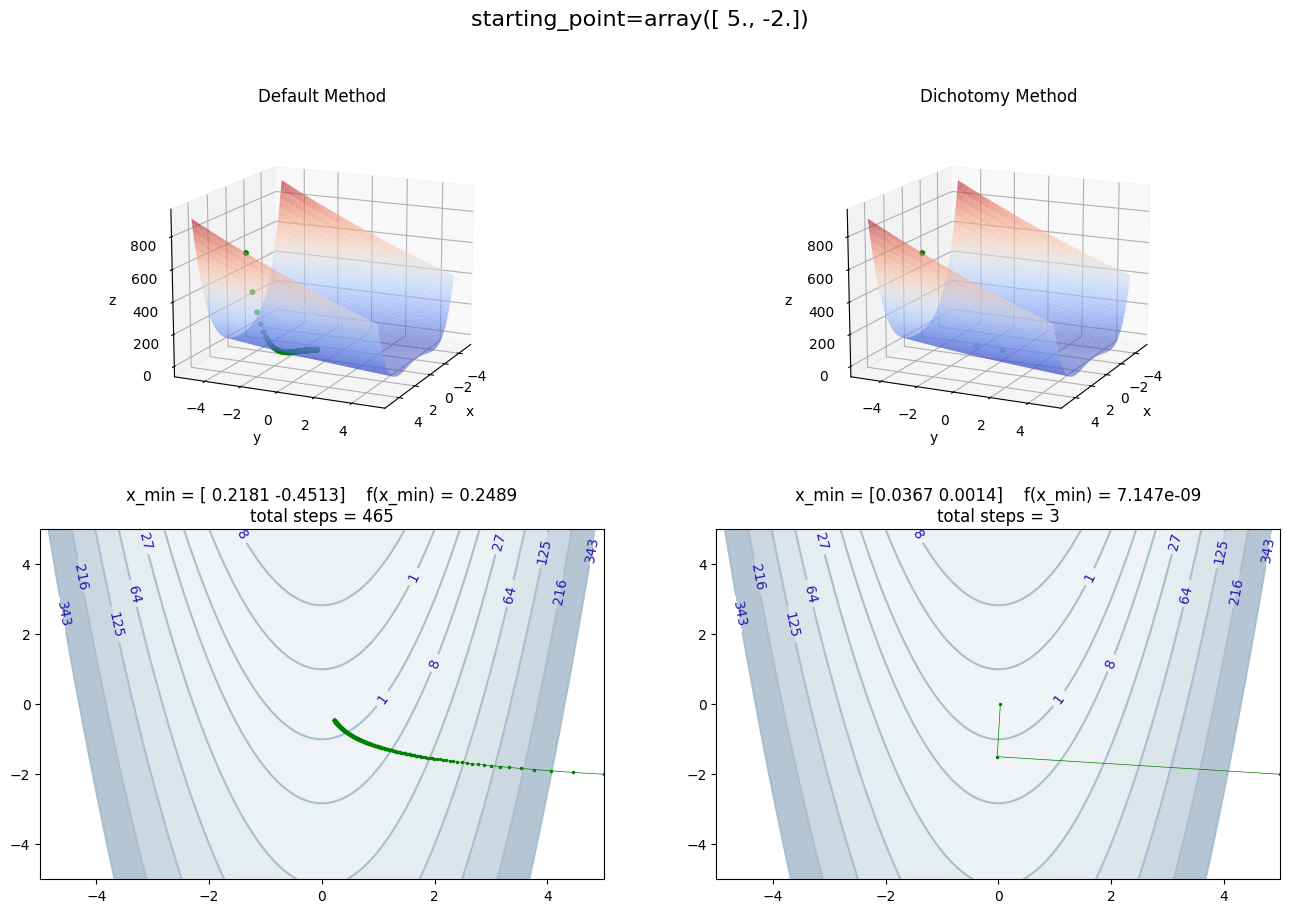

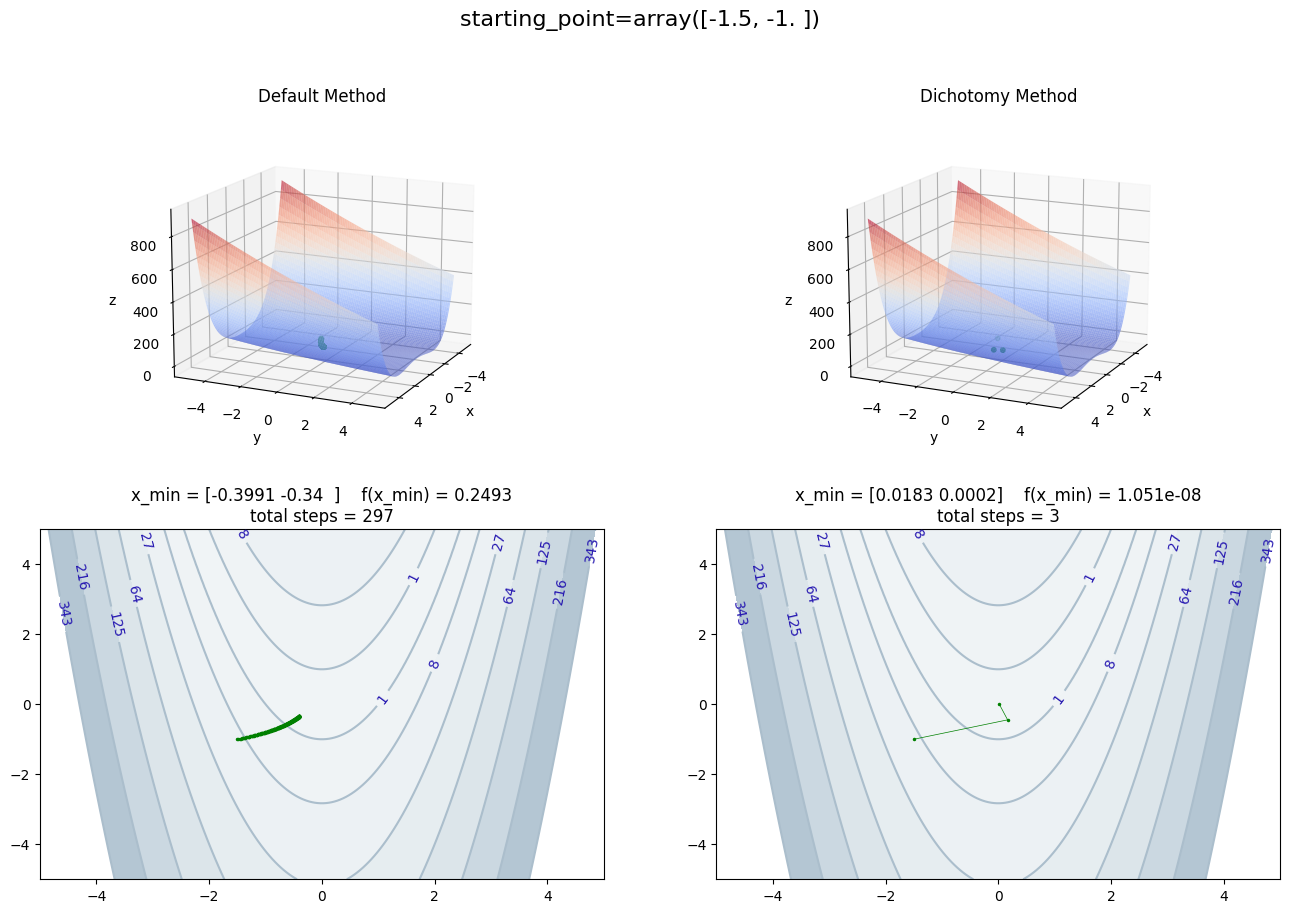

In [16]:
from graphs import plot3d_descent_double

for i in range(3):
    print(f"================== fn = {representations[i]} ==================")
    methods = [DefaultMethod(EPS), DichotomyMethod(fns[i])]
    for starting_point in starting_points:
        paths = []
        info = []
        for idx, method in enumerate(methods):
            optimizer = GradDescGeneral(fns[i], derivatives[i])
            x_min, path, convergence_steps = optimizer(
                starting_point=starting_point,
                iterations=N_ITERATIONS,
                linear_method=method,
                eps = EPS
            )
            
            paths.append(path)

            new_line = '\n'
            info.append(f"x_min = {np.around(x_min, decimals=4)}    f(x_min) = {fns[i](x_min):.4}{new_line}total steps = {convergence_steps}")

        plot3d_descent_double(
            fn=destructured_fns[i],
            paths=paths,
            info=info,
            angle=(15, 25),
            title=f"{starting_point=}"
        )


        plt.show()

##### После завершения этой серии опытов выяснилось, что метод градиентного спуска с дихотомией показывает лучшую сходимость (количество итераций уменьшается в 100 и более раз). Это логично, ведь на каждом шаге мы подбираем лучший learning rate => алгоритм может более "нагло" скатываться в локальный минимум.

### 5. Реализуйте генератор случайных квадратичных функций n переменных с числом обусловленности k.

In [17]:
def matrix_form(n, k):
    diag = np.sort(np.random.uniform(1, k, n))[::-1]
    diag[0], diag[-1] = k, 1
    E = np.diag(diag)
    Q, _ = linalg.qr(np.random.rand(n, n))
    return Q @ E @ Q.T

def generate_func(n, k):
    M = matrix_form(n, k)

    def f(args: np.ndarray):
        return args.T @ M @ args

    def grad(args: np.ndarray):
        return (M + M.T) @ args

    return f, grad


### 6. Исследуйте зависимость числа итераций T(n, k)

In [18]:
# cond_numbers = np.arange(2, 1000, 100)
# dims = np.arange(2, 1000, 100)
cond_numbers = [2 ** i for i in range(10)] + [1000]
dims = [2 ** i for i in range(10)] + [1000]

In [19]:
from tqdm import tqdm

ITERATIONS = 50_000

data = []

for dim in tqdm(dims):
    # print(f"N_dim = {dim}: ")
    for cond_number in cond_numbers:
        fn, derivative = generate_func(dim, cond_number)
        # print(f"\tConditional number = {cond_number}")
        optimizer = GradDescGeneral(fn, derivative)
        x_minimum, trace, iterations = optimizer(
            starting_point=np.array(np.random.randn(dim)),
            iterations=ITERATIONS,
            linear_method=DefaultMethod(EPS)
        )
        
        data.append([dim, cond_number, iterations])

100%|██████████| 11/11 [08:56<00:00, 48.78s/it] 


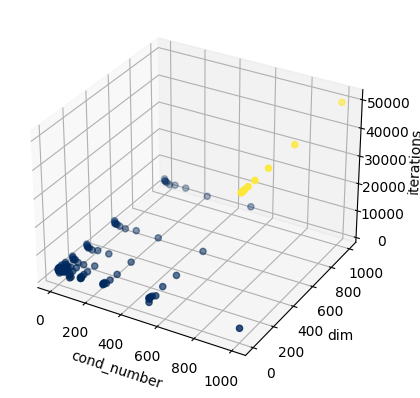

In [20]:
ax = plt.axes(projection='3d')

z = [x[2] for x in data]
x = [x[1] for x in data]
y = [x[0] for x in data]

ax.set_ylabel('dim')
ax.set_xlabel('cond_number')
ax.set_zlabel('iterations')

ax.scatter3D(x, y, z, c=z, cmap='cividis')

plt.show()

### 7. Для получения более корректных результатов проведите множественный эксперимент и усредните полученные значения числа итераций.

In [ ]:
from tqdm import tqdm

ITERATIONS = 50_000

data = []

N_EXPS = 10
avg = [[0 for j in range(len(cond_numbers))] for i in range(len(dims))]

for exp in N_EXPS:
    for i, dim in tqdm(enumerate(dims)):
        # print(f"N_dim = {dim}: ")
        for j, cond_number in enumerate(cond_numbers):
            fn, derivative = generate_func(dim, cond_number)
            # print(f"\tConditional number = {cond_number}")
            optimizer = GradDescGeneral(fn, derivative)
            x_minimum, trace, iterations = optimizer(
                starting_point=np.array(np.random.randn(dim)),
                iterations=ITERATIONS,
                linear_method=DefaultMethod(EPS)
            )

            avg[i][j].append([dim, cond_number, iterations])
        
    data.append([dim, cond_numbers, avg])

## Дополнительное задание
### Реализуйте одномерный поиск с учетом условий Вольфе и исследуйте его эффективность. Сравните полученные результаты с реализованными ранее методами.

In [21]:
def wolfe(fn, gradient, cur_x, projection, c1=1e-4, c2=0.9, max_iterations=100):
    cur_y = fn(cur_x)
    cur_grad = gradient(cur_x)

    def inner_loop(interval, made_iterations=0):
        if made_iterations == max_iterations:
            return EPS

        beta_l, beta_r = interval
        alpha = (beta_l + beta_r) / 2
        y_step = fn(cur_x + alpha * projection)

        if y_step > cur_y + c1 * alpha * cur_grad * projection:
            return inner_loop((beta_l, alpha), made_iterations + 1)
        else:
            step_grad = gradient(cur_x + alpha * projection)
            if step_grad * projection >= c2 * cur_grad * projection:
                return alpha

            else:
                return inner_loop(
                    interval=(beta_l, alpha),
                    made_iterations=made_iterations + 1
                ) if step_grad >= 0 else inner_loop(
                    interval=(alpha, beta_r),
                    made_iterations=made_iterations + 1
                )

    return inner_loop

In [22]:
class WolfeMethod:
    def __init__(self, fn, grad_fn, c1=EPS, c2=0.9, max_step_iterations=100):
        self.f = fn
        self.grad_f = grad_fn
        self.c1 = c1
        self.c2 = c2
        self.max_step_iterations = max_step_iterations

    def __call__(self, cur_x, gradient):
        phi = lambda lr: self.f(cur_x - lr * gradient)
        max_alpha = lin_constraint(phi)
        interval = 0, max_alpha
        alpha = wolfe(
            fn=self.f,
            gradient=self.grad_f,
            cur_x=cur_x,
            projection=gradient,
            c1=self.c1,
            c2=self.c2,
            max_iterations=self.max_step_iterations
        )(interval)
        
        return alpha

In [23]:
from math import cos, sin

FN = np.vectorize(lambda x: sin(x) * x)
FN_GRAD = np.vectorize(lambda x: cos(x) * x + sin(x))
ITERATIONS = 50_000

starting_point = 2.2

wolfeMethod = WolfeMethod(fn=FN, grad_fn=FN_GRAD, max_step_iterations=10)
optimizer = GradDescGeneral(FN, FN_GRAD)

minimum_x, trace, steps = optimizer(
    starting_point=starting_point,
    iterations=ITERATIONS,
    linear_method=wolfeMethod
)

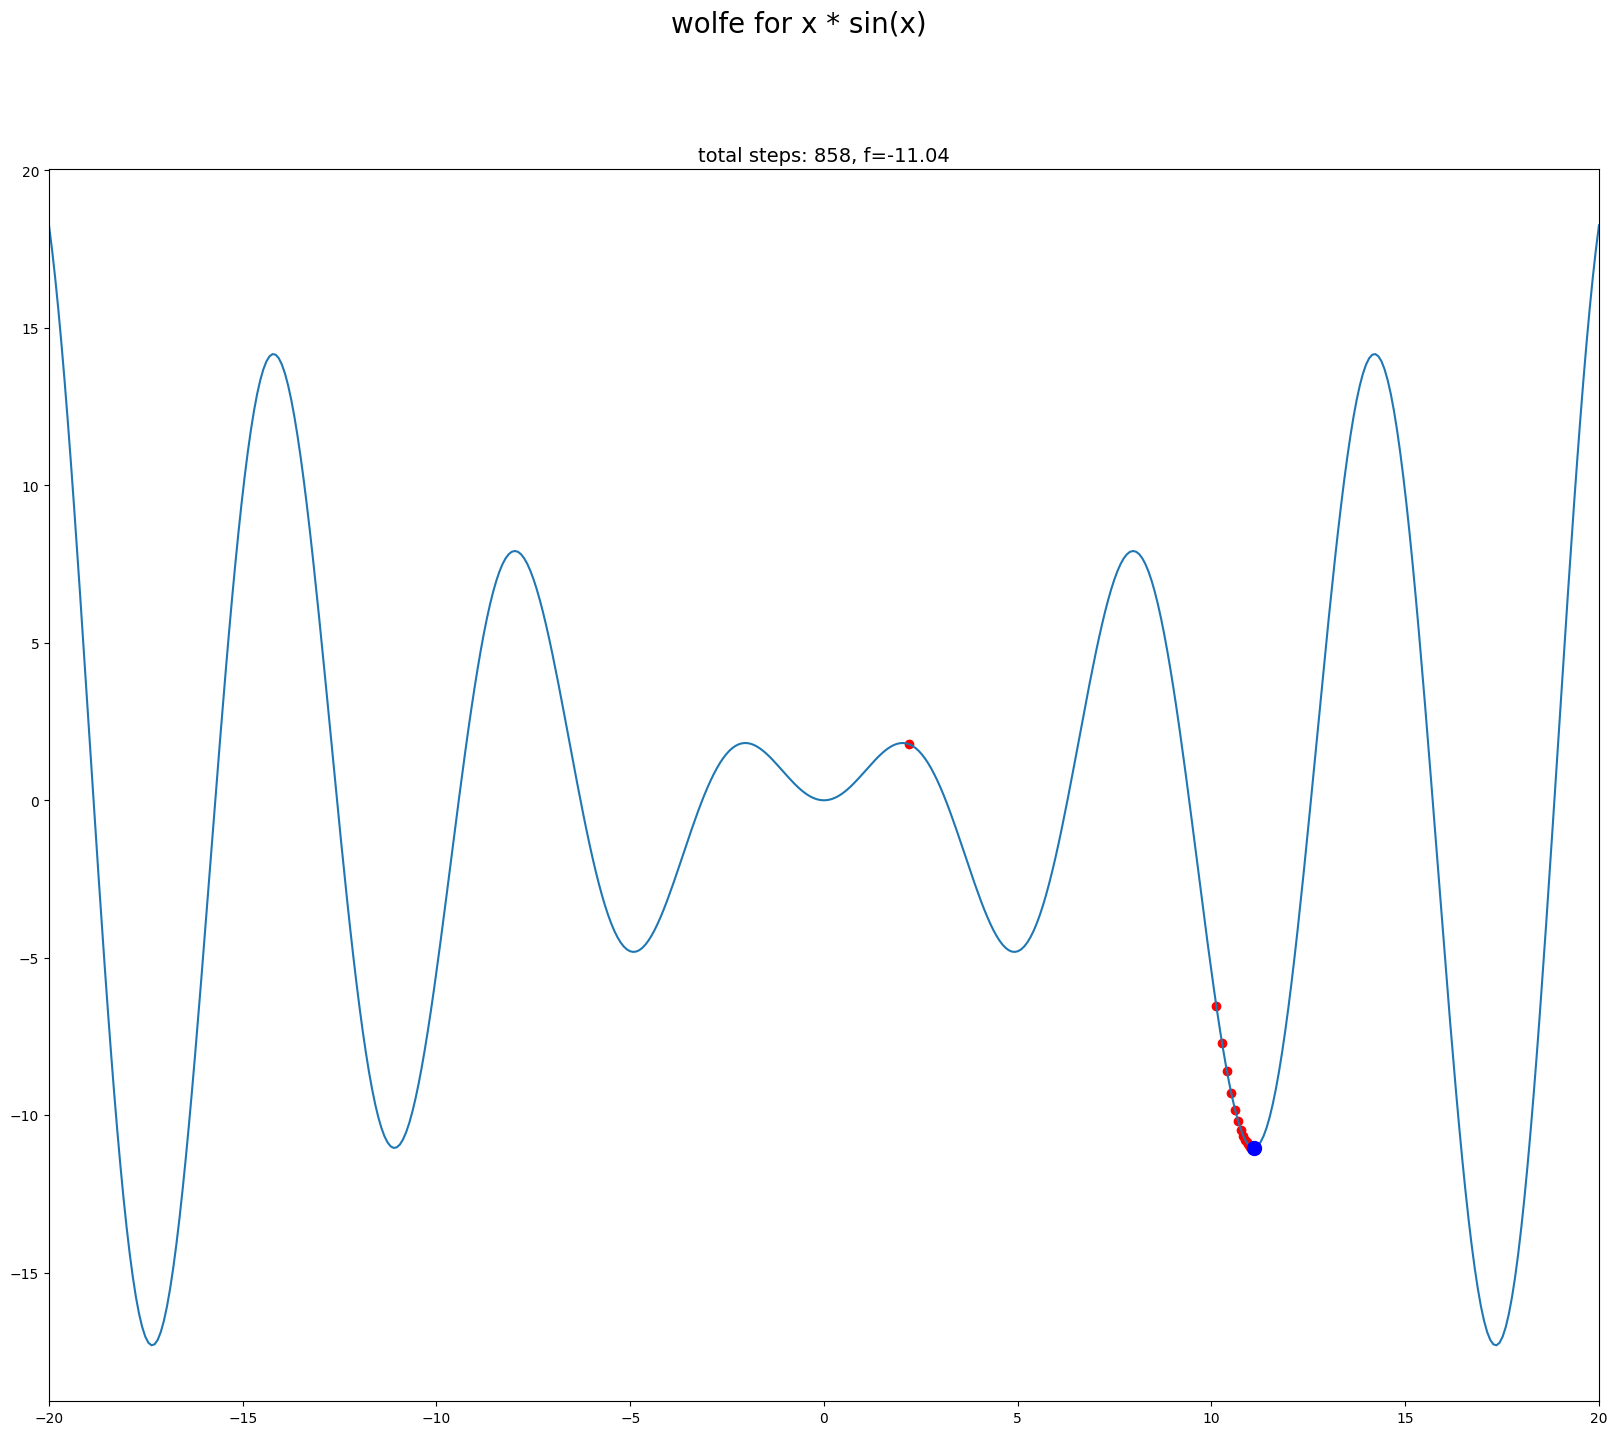

In [24]:
figure, ax = plt.subplots(figsize=(20, 16))
figure.suptitle("wolfe for x * sin(x)", fontsize=20)

ax.set_title(f"total steps: {steps}, f={FN(minimum_x):.4}", fontsize=14)
plot1d_descent(0, minimum_x, FN, trace, ax, freq=50, x_range=(-20, 20))

In [25]:
default = DefaultMethod(lr=1e-3)
optimizer = GradDescGeneral(FN, FN_GRAD)

minimum_x, trace, steps = optimizer(
    starting_point=starting_point,
    iterations=ITERATIONS,
    linear_method=default
)

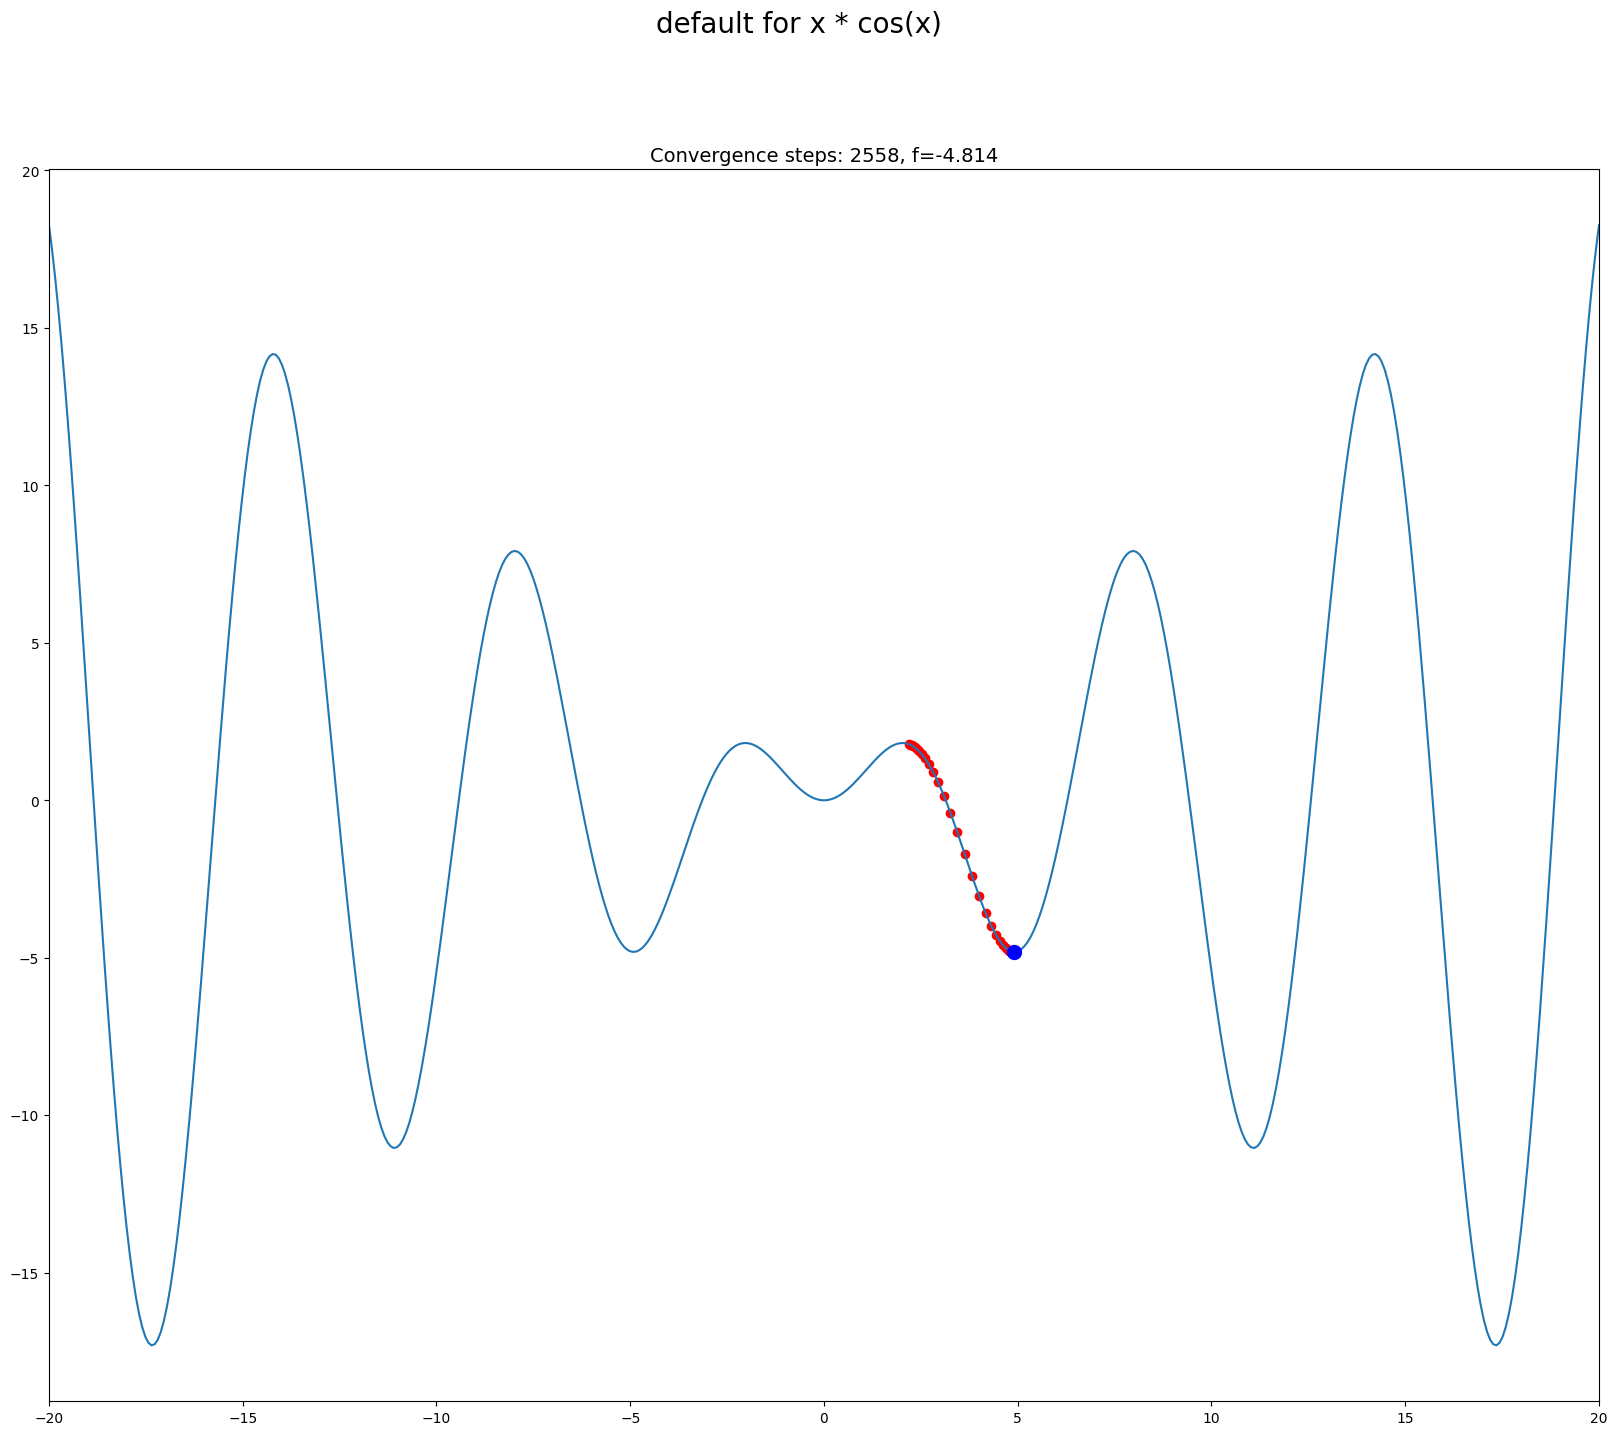

In [26]:
figure, ax = plt.subplots(figsize=(20, 16))
figure.suptitle("default for x * cos(x)", fontsize=20)

ax.set_title(f"Convergence steps: {steps}, f={FN(minimum_x):.4}", fontsize=14)
plot1d_descent(0, minimum_x, FN, trace, ax, freq=50, x_range=(-20, 20))